<table>
<tr>
    <td width=10%><img src="./img/logo_lri.jpg"></td>
    <td width=30%><img src="./img/medi-chal_logo.png" height=15%></img></td>
</tr>

</table>

<br/><br/><div id="top"></div>

<center><a style="font-size: 40pt; font-weight: bold">To be or not to be?</a></center>
<br/>
<center><a style="font-size: 22pt; font-weight: bold">Binary Classification on Artificial Medical Data</a></center>
<br/>

---

## Done by Mykola Liashuha, Paavo Camps and Louis Lamalle. Top-2 result on 06.12.2020 by username mykola_liashuha

# TP1 Instructions


The goal of this TP is to work on a mortality prediction problem and to participate into the "To be or not to be?" challenge.

A fresh instance of the challenge can be found here: https://competitions.codalab.org/competitions/27605

* **Step 1:** Sign up to https://competitions.codalab.org
* **Step 2:** Go through the competition's pages and read them carefully in order to understand the problem.
* **Step 3:** Download the dataset from "Participate > Files > Public Data" page. Put the "public_data" folder in the same folder as the folder containing this notebook.
* **Step 4:** Go though this notebook. You'll have to read, run, **code your own methods** and **answer quetions**. Use "code" cell for coding and "markdown" cell to answer questions. 

_Remark: You may need to look up on the internet for information or documentation._

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import time
from zipfile import ZipFile

import matplotlib.pyplot as plt
import numpy as np

# IMPORTS
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    roc_auc_score,
)
from sklearn.model_selection import train_test_split

### Question 1: Briefly explain the task.

We are to classify patients according to their given information into people who will survive vs people who will have died. This way we might be able to predict who needs more attention.

### Question 2: What is the metric used in the challenge?


The metric that is used balanced accuracy, the percentage of rightfully classified instances. In balanced accuracy missclassifing(or rightly classifying for that matter) a class that is less represented has a stronger influence on the accuracy score to prevent models to simply learn to answer with the most represented class.

### Question 3: What is up-sampling? Why it may be worth a try for this problem?

When upsampling one amplifies the signal of a class by reusing instances of it in the learning process. This is interesting for this task since we have very little data for the class of people who died in the hospital. Reusing some of the "dead" cases trains the model to make more balanced predictions. In our case we had 27 times more data for "not-dead" class, that is why we just upsampled (copying exsiting sample of "dead" class) "dead" class instances.


# 1. Load data

In [5]:
features = pd.read_csv(
    "../public_data/mimic_synthetic_feat.name", header=None
).values.flatten()
labels = pd.read_csv(
    "../public_data/mimic_synthetic_label.name", header=None
).values.flatten()
X = pd.read_csv(
    "../public_data/mimic_synthetic_train.data",
    header=None,
    names=features,
    sep=" ",
)
y = pd.Series(
    pd.read_csv(
        "../public_data/mimic_synthetic_train.solution",
        header=None,
        names=labels,
        sep=" ",
    ).values.flatten()
)

In [6]:
X.head()

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,GENDER,...,Eyeinfectn,Othereyedx,Otitismedia,Dizziness,Othereardx,Othnervdx,Hrtvalvedx,Carditis,HTN,Htncomplicn
0,45524,108398,2128-05-15_23:42:00,2132-07-23_15:00:00,Private,ENGL,CATHOLIC,DIVORCED,WHITE,F,...,0,0,0,0,0,0.0,0,0,0,0
1,50520,186416,2134-03-17_03:59:00,2113-03-06_12:05:00,Private,ENGL,UNOBTAINABLE,SINGLE,WHITE,M,...,0,0,0,0,0,0.0,0,0,0,1
2,17956,126413,2164-04-05_17:32:00,2180-09-20_16:30:00,Medicaid,SPAN,CATHOLIC,WIDOWED,OTHER,M,...,0,0,0,0,0,0.0,0,0,0,0
3,90258,109355,2102-09-08_00:58:00,2166-06-26_15:30:00,Medicare,ENGL,NOT_SPECIFIED,MARRIED,WHITE,M,...,0,0,0,0,0,0.0,0,0,1,0
4,25159,123784,2163-08-06_12:07:00,2147-01-14_18:40:00,Medicare,ENGL,UNOBTAINABLE,MARRIED,UNKNOWN/NOT_SPECIFIED,F,...,0,0,0,0,0,0.0,0,0,0,0


This is the **training set**. This means that have access to the labels and you can use it in anyway you want to prepare your model.

Later on, you'll make your model draws predictions from the **testing set** in order to upload them on Codalab and get a score on unseen labels.

In [7]:
# Load testing set
X_test = pd.read_csv(
    "../public_data/mimic_synthetic_test.data",
    header=None,
    names=features,
    sep=" ",
)

#### Variable types

In [8]:
types = pd.read_csv(
    "../public_data/mimic_synthetic_feat.type", header=None
).set_index(features)[0]
print(types.value_counts())

Numerical      226
Binary         107
Categorical      8
Name: 0, dtype: int64


# 2. Pre-processing

Include here any code, text, or plot related to the data pre-processing such as dimensionality reduction,
encoding, etc.

In [9]:
pd.unique(X[['Tuberculosis', 'Immuniz/scrn', 'AcuteMI', 'Coronathero', 'Chestpain', 'Pulmhartdx', 'Othheartdx', 'Conduction', 'Dysrhythmia', 'Cardiaarrst', 'chf;nonhp', 'AcuteCVD', 'Hd/nckcancr', 'Precereoccl', 'OtherCVD', 'TIA', 'LateeffCVD', 'Peripathero', 'Aneurysm', 'Artembolism', 'Otcirculdx', 'Phlebitis', 'Varicosevn', 'Esophcancer', 'Hemmorhoids', 'Othveindx', 'Pneumonia', 'Influenza', 'Tonsillitis', 'Bronchitis', 'Otuprspin', 'COPD', 'Asthma', 'Asppneumon', 'Stomchcancr', 'Pleurisy', 'Adltrespfl', 'Lungexternl', 'Othlowresp', 'Otupprresp', 'Intestinfct', 'Teethdx', 'Mouthdx', 'Esophgealdx', 'Gasduoulcer', 'Coloncancer', 'Gastritis', 'Otdxstomch', 'Appendicitis', 'Abdomhernia', 'Ulceratcol', 'Intobstruct', 'Diverticulos', 'Anal/rectal', 'Peritonitis', 'Biliarydx', 'Rctm/anusca', 'Othliverdx', 'Pancreasdx', 'GIhemorrhag', 'Gastroent', 'OtherGIdx', 'Nephritis', 'Acrenlfail', 'Chrrenfail', 'UTI', 'Liver/ibdca', 'Urinstone', 'Otdxkidney', 'Otdxbladdr', 'OtherGUdx', 'BPH', 'Infmalegen', 'Othmalegen', 'Breastdx', 'PID', 'Endometrios', 'Pancreascan', 'Prolapse', 'Menstrualdx', 'Ovariancyst', 'Menopausldx', 'Feminfertil', 'Otfemalgen', 'Contraceptiv', 'Spontabortn', 'Inducabortn', 'Abortcompl', 'GI/peritcan', 'Ectopicpreg', 'Otpregcomp', 'Hemorrpreg', 'HTNinpreg', 'Earlylabor', 'Longpregncy', 'DMinpreg', 'Malposition', 'Pelvicobstr', 'Prevc-sectn', 'Brnch/lngca', 'Fetaldistrs', 'Amniosdx', 'Umbilcord', 'OB-relatedperintrauma', 'Otcomplbir', 'Nmlpreg/del', 'Skininfectn', 'Otinflskin', 'Ulcerskin', 'Septicemia', 'Otrespirca', 'Othskindx', 'Infectarth', 'Rheumarth', 'Osteoarthros', 'Otjointdx', 'Backproblem', 'Osteoporosis', 'Pathologfx', 'Acqfootdef', 'Otacqdefor', 'Bone/ctcncr', 'SLE', 'Otconntiss', 'Otbonedx', 'Cardiacanom', 'GIconganom', 'guconganom', 'Nervcongan', 'Otconganom', 'Liveborn', 'Lowbirthwt', 'Skinmelanom', 'Birthasphyx', 'Respdistres', 'Perintjaund', 'Birthtrauma', 'Otperintdx', 'Jointinjury', 'Fxhip', 'Spincorinj', 'Fxskullfac', 'Fxarm', 'Non-epithca', 'Fxleg', 'Othfracture', 'Sprain', 'Intracrninj', 'Crushinjury', 'Opnwndhead', 'Opnwndextr', 'Complicdevi', 'Complicproc', 'Superficinj', 'Breastcancr', 'Burns', 'Poisonpsych', 'Poisnotmed', 'Poisnnonmed', 'Otherinjury', 'Syncope', 'FUO', 'Lymphenlarg', 'Gangrene', 'Shock', 'Uteruscancr', 'Nausea/vomit', 'Abdomnlpain', 'Fatigue', 'Allergy', 'Socialadmin', 'Exam/eval', 'Otaftercare', 'Otherscreen', 'Unclassified', 'Cervixcancr', 'ECodes:Cut/pierce', 'ECodes:Drowning/submersion', 'ECodes:Fall', 'ECodes:Fire/burn', 'ECodes:Firearm', 'ECodes:Machinery', 'ecodes:motorvehicletraffic(mvt)', 'ECodes:Pedalcyclist-notMVT', 'ECodes:Pedestrian-notMVT', 'ecodes:transport-notmvt', 'ECodes:Natural/environment', 'ECodes:Overexertion', 'ECodes:Poisoning', 'ECodes:Struckby-against', 'ECodes:Suffocation', 'ECodes:Adverseeffectsofmedicalcare', 'ECodes:Adverseeffectsofmedicaldrugs', 'ECodes:Otherspecifiedandclassifiable', 'ecodes:otherspecified-nec', 'ECodes:Unspecified', 'ECodes:Placeofoccurrence', 'Ovarycancer', 'Femgenitca', 'Prostatecan', 'Othbactinf', 'Testiscancr', 'Malgenitca', 'Bladdercncr', 'Kidny/rnlca', 'Urinyorgca', 'Brain/nscan', 'Thyroidcncr', 'Hodgkin-sds', 'Non-Hodglym', 'Leukemias', 'Mycoses', 'Multmyeloma', 'Otprimryca', '2ndarymalig', 'Maligneopls', 'Neoplsmunsp', 'Maintchem/r', 'Bnignutneo', 'Otbnignneo', 'Thyroiddsor', 'DiabMelnoc', 'HIVinfectn', 'DiabMelw/cm', 'Otendodsor', 'Nutritdefic', 'Hyperlipidem', 'Gout/otcrys', 'Fluid/elcdx', 'Cysticfibro', 'Immunitydx', 'Otnutritdx', 'Anemia', 'Hepatitis', 'Acutp-hanm', 'Sicklecell', 'Coag/hemrdx', 'Whtblooddx', 'Othematldx', 'Adjustmentdisorders', 'Anxietydisorders', 'Attention-deficit/conduct/disruptivebeha', 'Delirium/dementia/amnestic/othercognitiv', 'Developmentaldisorders', 'Disordersusuallydiagnosedininfancy/ch', 'ImpulsecontroldisordersNEC', 'Mooddisorders', 'Personalitydisorders', 'Schizophreniaandotherpsychoticdisorde', 'Alcohol-relateddisorders', 'Substance-relateddisorders', 'Suicideandintentionalself-inflictedin', 'Screeningandhistoryofmentalhealthan', 'Miscellaneousmentaldisorders', 'Viralinfect', 'Meningitis', 'Encephalitis', 'OthCNSinfx', 'Parkinson-s', 'Othinfectns', 'MS', 'OtheredCNS', 'Paralysis', 'Epilepsy/cnv', 'Headache/mig', 'Coma/brndmg', 'Cataract', 'Retinaldx', 'Glaucoma', 'Blindness', 'SexualInfxs', 'Eyeinfectn', 'Othereyedx', 'Otitismedia', 'Dizziness', 'Othereardx', 'Othnervdx', 'Hrtvalvedx', 'Carditis', 'HTN', 'Htncomplicn']].values.ravel('K'))


array([ 0.,  1., nan])

We decided to create an other feature: length stay.
For the encoding we use the function cat.codes which encode object in number.  It turned out that using one-got-encoding gave worse results rather than simle categorization with numbers from 1,2,3,... . 

In [10]:
columns = X.columns[X.dtypes == 'object'].tolist() + ["AGE"]
def clearing(df):
    df = df.copy()
    cols = ['SUBJECT_ID', 'HADM_ID', "PID"]#[col for col in df.columns if "ID" in col]
    for col in cols:
        df.pop(col)
    df["ADMITTIME"] = pd.to_datetime(df["ADMITTIME"].apply(lambda a: a.replace("_", " "))).apply(lambda x:x.timestamp())
    df["DISCHTIME"] = pd.to_datetime(df["DISCHTIME"].apply(lambda a: a.replace("_", " "))).apply(lambda x:x.timestamp())
    df["length_stay"] = df["DISCHTIME"] - df["ADMITTIME"]
    df["length_stay"] = (df["length_stay"] - df["length_stay"].min())/(df["length_stay"].max() - df["length_stay"].min())
    df["ADMITTIME"] = (df["ADMITTIME"] - df["ADMITTIME"].min())/(df["ADMITTIME"].max() - df["ADMITTIME"].min())
    df["DISCHTIME"] = (df["DISCHTIME"] - df["DISCHTIME"].min())/(df["DISCHTIME"].max() - df["DISCHTIME"].min())
#     df = pd.get_dummies(df)
#     df.pop('ADMITTIME')
#     df.pop('DISCHTIME')
    columns = df.columns[df.dtypes == 'object']
    for column in columns:
        df[column] = df[column].astype('category').cat.codes
        

    return df

df = clearing(X)
df

,ADMITTIME,DISCHTIME,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,GENDER,AGE,HR_MIN_DAY1,...,Othereyedx,Otitismedia,Dizziness,Othereardx,Othnervdx,Hrtvalvedx,Carditis,HTN,Htncomplicn,length_stay
0,0.258189,0.296698,3,45,3,0,36,0,21,57.207630,...,0,0,0,0,0.0,0,0,0,0,0.512322
1,0.312119,0.117548,3,45,19,4,36,1,39,79.331400,...,0,0,0,0,0.0,0,0,0,1,0.390105
2,0.589911,0.741872,1,63,3,6,30,1,40,118.230290,...,0,0,0,0,0.0,0,0,0,0,0.571801
3,0.020775,0.610275,2,45,14,2,36,1,75,83.780380,...,0,0,0,0,0.0,0,0,1,0,0.801241
4,0.583756,0.430524,2,45,19,2,35,0,55,60.878613,...,0,0,0,0,0.0,0,0,0,0,0.411773
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79994,0.888767,0.320283,2,45,14,5,36,0,76,56.035793,...,0,0,0,0,0.0,0,0,1,0,0.194027
79995,0.622278,0.189879,1,45,10,2,36,0,38,55.126850,...,0,0,0,0,1.0,0,0,0,0,0.265391
79996,0.395761,0.380310,3,45,14,3,36,0,90,74.281746,...,0,0,0,0,0.0,0,0,0,0,0.484024
79997,0.771614,0.010479,0,45,3,2,13,1,57,79.256140,...,0,0,0,0,0.0,0,0,1,0,0.093013


In [11]:
X_encoded = clearing(X)

In [12]:
X_encoded

,ADMITTIME,DISCHTIME,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,GENDER,AGE,HR_MIN_DAY1,...,Othereyedx,Otitismedia,Dizziness,Othereardx,Othnervdx,Hrtvalvedx,Carditis,HTN,Htncomplicn,length_stay
0,0.258189,0.296698,3,45,3,0,36,0,21,57.207630,...,0,0,0,0,0.0,0,0,0,0,0.512322
1,0.312119,0.117548,3,45,19,4,36,1,39,79.331400,...,0,0,0,0,0.0,0,0,0,1,0.390105
2,0.589911,0.741872,1,63,3,6,30,1,40,118.230290,...,0,0,0,0,0.0,0,0,0,0,0.571801
3,0.020775,0.610275,2,45,14,2,36,1,75,83.780380,...,0,0,0,0,0.0,0,0,1,0,0.801241
4,0.583756,0.430524,2,45,19,2,35,0,55,60.878613,...,0,0,0,0,0.0,0,0,0,0,0.411773
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79994,0.888767,0.320283,2,45,14,5,36,0,76,56.035793,...,0,0,0,0,0.0,0,0,1,0,0.194027
79995,0.622278,0.189879,1,45,10,2,36,0,38,55.126850,...,0,0,0,0,1.0,0,0,0,0,0.265391
79996,0.395761,0.380310,3,45,14,3,36,0,90,74.281746,...,0,0,0,0,0.0,0,0,0,0,0.484024
79997,0.771614,0.010479,0,45,3,2,13,1,57,79.256140,...,0,0,0,0,0.0,0,0,1,0,0.093013


In [13]:
X_test_encoded = clearing(X_test)

In [14]:
X_test_encoded = X_test_encoded.reindex(columns = X_encoded.columns, fill_value=0)

In [15]:
X_encoded = X_encoded.reindex(columns = X_test_encoded.columns, fill_value=0)

We decided to fill the Nan values with the pad method. The results of filling NaN values with mean value turned out to be worse.

In [16]:
X_test_encoded = X_test_encoded.fillna(method="pad")#(X.mean())#(method="pad")
X_encoded = X_encoded.fillna(method="pad")#(X_encoded.mean())#(method="pad")

In [17]:
nan_values = X_encoded.isna()
nan_columns = nan_values.any()

columns_with_nan = X_encoded.columns[nan_columns].tolist()
print(columns_with_nan)

[]


Here is a functon to normlize the data with standarsization

In [18]:
saved = {}
def normalize(df, use_saved=False):
    result = df.copy()
    for feature_name in df.columns :
        if feature_name not in columns or True:
            if use_saved:
                std_value, mean_value = saved[feature_name]
            else:
                std_value = df[feature_name].std()
                mean_value = df[feature_name].mean()
                saved[feature_name] = (std_value, mean_value)
            second = std_value
            if second == 0:
                result[feature_name] = 0
            else:
                result[feature_name] = (df[feature_name] - mean_value) / second
    return result

We tried a PCA but it was not really useful so we decided to don't use it

In [19]:
from sklearn.decomposition import PCA
X_encoded_copy = X_encoded.copy()


# mod = PCA(100)
# X_encoded_copy = mod.fit_transform(X_encoded_copy)
# 
# X_encoded_copy = pd.DataFrame(X_encoded_copy)

X_encoded_copy = normalize(X_encoded_copy)

In [20]:
x_train, x_valid, y_train, y_valid = train_test_split(
    X_encoded_copy, y, test_size=0.2
)  

Here is our actual resampling

In [21]:
from sklearn.utils import resample

def upsample(x_train, y_train):
    df_majority = x_train[y_train==0]
    df_minority = x_train[y_train==1]

    # Upsample minority class
    df_minority_upsampled = resample(df_minority, 
                                     replace=True,     # sample with replacement
                                     n_samples=int(df_majority.shape[0]),    # to match majority class
                                     random_state=123) # reproducible results

    # Combine majority class with upsampled minority class
    df_upsampled = pd.concat([df_majority, df_minority_upsampled])

    new_y = np.concatenate([np.zeros(df_majority.shape[0]), np.ones(df_minority_upsampled.shape[0])])
    return df_upsampled, new_y

df_upsampled, new_y = upsample(x_train, y_train)


# 3. Model

Include here any code, text, or plot related to the classification algorithm(s), the hyperparameters, the validation
method, etc.

In [23]:
from sklearn.svm import SVC, LinearSVC
from  sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
import numpy as np

clf = XGBClassifier(n_estimators=500, max_depth=2, n_jobs=-1, tree_method='gpu_hist', gpu_id=0)
# clf = RandomForestClassifier(**best_rf_params)
# clf = LogisticRegression(solver="saga", penalty="l2", fit_intercept=True)
# clf = SVC()
# clf = LinearSVC(random_state=0, tol=1e-5, max_iter=100, dual=False)


In [24]:
clf.fit(df_upsampled, new_y)  # training
y_pred = clf.predict(x_valid)  # predictions
score = balanced_accuracy_score(y_valid, y_pred)  # scoring
print("Balanced accuracy score: {}".format(score))

Balanced accuracy score: 0.5044593539957043


We fist try with logistic regression with differenct parameters. The best configuration is with penalty="l2" and solver="saga". Our accuracy on the validation test is about 0.74

In [91]:
clf = LogisticRegression(solver="saga", penalty="l2", max_iter=1000 ,fit_intercept=True).fit(df_upsampled, new_y)
y_pred = clf.predict(x_valid)
logistic_score = balanced_accuracy_score(y_valid, y_pred)
print(logistic_score)

0.7411332


We try the Linear SVC with different parameters. Our best accuracy was 0.74 too on the validation set with the parameters dual=false, max_iter=100

In [80]:
import numpy as np
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC, LinearSVC

clf = make_pipeline(StandardScaler(), LinearSVC(random_state=0, tol=1e-5, max_iter=100, dual=False))
clf.fit(df_upsampled, new_y)
y_pred = clf.predict(x_valid)  # predictions
LinearSVC_score = balanced_accuracy_score(y_valid, abs(y_pred.round()))  # scoring
print(LinearSVC_score)

0.7415122341562164


In [25]:
best_rf_params = {'n_estimators': 20, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 80, 'class_weight': 'balanced', 'bootstrap': True}

from sklearn.model_selection import RandomizedSearchCV


n_estimators = [int(x) for x in np.linspace(start = 20, stop = 500, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
class_weight = ["balanced"]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap, 
               'class_weight': class_weight} 


rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=1, random_state=42, n_jobs = 4)# Fit the random search model

#We commented this last part out because running it takes a very long time
#rf_random.fit(df_upsampled, new_y)


We tried optimizing the RandomForestClassifier with a RandomSearch. This took quite a long time(2.5h) but sadly did not give us results(0.50445) that where much better than the non-optimised RandomForrestClassifier and is much  than other things used.

<br>
The parameters we tried to tune:
n_estimators: number of estimators for RandomForestClassifier
max_depth: Maximum tree depth for each tree in the random forest.
max_features: max_features is the amount of features that are looked at before deciding on the way to split
min_samples_split: minimum number of samples required to split
min_samples_leaf: the minimum depth before the tree can end up in a leaf
bootstrap: if true the trees are build with bootstrap samples instead of all the data
class_weight: if there is a unequal amount of data a 'balanced' class weight will give a higher penalty for guessing it wrong to avoid the model from being overcautiaus with the classifying of minortiy classes

In [ ]:
n_estimators = [10, 20, 30, 50, 80, 100, 200, 300, 500]
max_depth=[1,2,3,4,5,6]#,7,9,11,13,15,20,25,30,40,50]
seed=42

res = []
clf = XGBClassifier(n_estimators=1, max_depth=1, n_jobs=-1, tree_method='gpu_hist', gpu_id=0, seed=seed)

for n in n_estimators:
    for mx in max_depth:
        print("n_estimators", n, "max_depth", mx)
        clf.__init__(n_estimators=n, max_depth=mx, n_jobs=-1, tree_method='gpu_hist', gpu_id=0, seed=seed)
        clf.fit(df_upsampled, new_y)  # training
        y_pred = clf.predict(x_valid)  # predictions
        score = balanced_accuracy_score(y_valid, y_pred)  # scoring
        print("Balanced accuracy score: {}".format(score))
        res.append({"n_estimators": n, "max_depth":mx, "score":score})

In [ ]:
res = sorted(res, key=lambda a: a["score"], reverse=True)
print("Best XGBoost model", res[0])

XGBoost is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable. It implements machine learning algorithms under the Gradient Boosting framework. As well as, this model uses tree structure, and so far it is one of the most promising models in machine learning world
In this experiment we optimized such parameters:
- n_estimators: number of estimators for XGBoost classifier
- max_depth: Maximum tree depth for base learners.

As best results we got not very deep tree model with 500 estimators which are maximum 2 depth trees. The best result is 0.758 which is in top-10 in challange.

In [109]:
from keras.callbacks import Callback

class MyLogger(Callback):
    def on_epoch_end(self, epoch, logs=None):
        y_pred = model.predict(x_valid).reshape(-1)  # predictions
        y_pred[y_pred <= 0.5] = 0
        y_pred[y_pred>0.5] = 1
        score = balanced_accuracy_score(y_valid, y_pred)  # scoring
        print("Balanced accuracy score: {}".format(score))

model = new_model([32,16])
history = model.fit(df_upsampled, new_y, epochs=10, batch_size=1024, validation_data=(x_valid, y_valid), callbacks=[MyLogger()])

Train on 123496 samples, validate on 16000 samples
Epoch 1/10
123496/123496 [==============================] - 2s 12us/step - loss: 0.6893 - accuracy: 0.6015 - val_loss: 0.6649 - val_accuracy: 0.6581
Balanced accuracy score: 0.7099160168592031
Epoch 2/10
123496/123496 [==============================] - ETA: 0s - loss: 0.5882 - accuracy: 0.69 - 1s 7us/step - loss: 0.5870 - accuracy: 0.7009 - val_loss: 0.5597 - val_accuracy: 0.7425
Balanced accuracy score: 0.7421422242827704
Epoch 3/10
123496/123496 [==============================] - 1s 7us/step - loss: 0.5471 - accuracy: 0.7366 - val_loss: 0.5009 - val_accuracy: 0.7693
Balanced accuracy score: 0.7516051417630296
Epoch 4/10
123496/123496 [==============================] - 1s 7us/step - loss: 0.5276 - accuracy: 0.7500 - val_loss: 0.4791 - val_accuracy: 0.7834
Balanced accuracy score: 0.7615350009552158
Epoch 5/10
123496/123496 [==============================] - 1s 7us/step - loss: 0.5093 - accuracy: 0.7642 - val_loss: 0.4663 - val_accurac

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


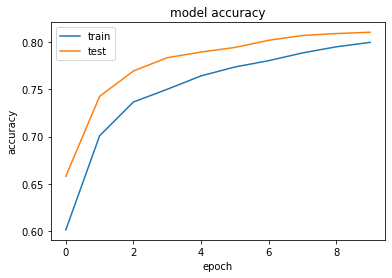

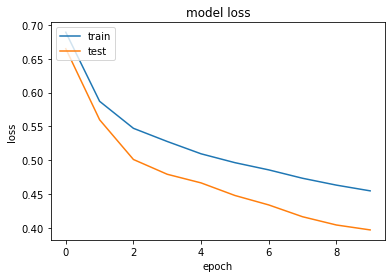

In [110]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [102]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
import keras
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
import gc

from keras.callbacks import Callback

class MyLogger(Callback):
    def on_epoch_end(self, epoch, logs=None):
        y_pred = model.predict(x_valid).reshape(-1)  # predictions
        y_pred[y_pred <= 0.5] = 0
        y_pred[y_pred>0.5] = 1
        score = balanced_accuracy_score(y_valid, y_pred)  # scoring
#         print("Balanced accuracy score: {}".format(score))
        model.accurs.append(score)
        gc.collect()

def new_model(layers, dropout=0.5, lr=0.001):
    model = Sequential()
    
    
    for i, layer in enumerate(layers):
        if i == 0:
            model.add(Dense(layer, input_dim=339))
        else:
            model.add(Dense(layer))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(Dropout(dropout))


    model.add(Dense(1, activation='sigmoid'))
    
    optim = Adam(lr=lr)

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


In [1]:
from itertools import combinations  
from itertools import permutations  
from keras import backend as K

inp = [8,16,32,64,128]
lrs = [0.001, 0.005, 0.0001]
dropouts = [0.5, 0.2, 0.7]
    
perm = list(permutations(inp)) 
perm = [sorted(p, reverse=True) for p in perm]
perm = np.unique(perm, axis=0).tolist()

for i in range(2, len(inp)):
    comb = list(combinations(inp, i))
    comb = np.unique(comb, axis=0).tolist()
    comb = [sorted(c, reverse=True) for c in comb]

    perm = perm + comb

    
perm = [[128,64,32,16,8]]
res = []
for lr in lrs:
    for drop in dropouts:
        for pair in perm:
            print(pair, "lr",lr, "dropout_rate",drop)
            model = new_model(pair, lr=lr, dropout=drop)
            model.accurs = []
            history = model.fit(df_upsampled.values, new_y, epochs=20, batch_size=2048, validation_data=(x_valid, y_valid), callbacks=[MyLogger()], verbose=0)
            y_pred = model.predict(x_valid).reshape(-1)  # predictions
            y_pred[y_pred <= 0.5] = 0
            y_pred[y_pred>0.5] = 1
            score = balanced_accuracy_score(y_valid, y_pred)  # scoring
            res.append({"pair":pair, "lr":lr, "dropout_rate":drop, "history":history, "accurs":model.accurs, "max_score":max(model.accurs)})
            del model
            
            K.clear_session()

In [6]:
res = sorted(res, key=lambda a: a["max_score"], reverse=True)
print("Best DNN model", res[0])
# print("Best DNN model {'pair': [128, 64, 32, 16, 8], 'lr': 0.001, 'dropout_rate': 0.5, 'history': <keras.callbacks.callbacks.History object at 0x7f737290c0f0>, 'accurs': [0.5231719239244358, 0.6471469673295762, 0.7092826653021456, 0.7119932111094215, 0.725823093864326, 0.7340057720554363, 0.7386150110668328, 0.7426913071833678, 0.7578117253524301, 0.75986178487463, 0.7632993689792232, 0.7646416475585713, 0.7711369366477523, 0.7811504663147898, 0.7836379928755983, 0.7866379928755983, 0.7730920556564469, 0.7679001792397291, 0.7698077694586787, 0.7682368610114196], 'max_score': 0.7866379928755983}")

Best DNN model {'pair': [128, 64, 32, 16, 8], 'lr': 0.001, 'dropout_rate': 0.5, 'history': <keras.callbacks.callbacks.History object at 0x7f737290c0f0>, 'accurs': [0.5231719239244358, 0.6471469673295762, 0.7092826653021456, 0.7119932111094215, 0.725823093864326, 0.7340057720554363, 0.7386150110668328, 0.7426913071833678, 0.7578117253524301, 0.75986178487463, 0.7632993689792232, 0.7646416475585713, 0.7711369366477523, 0.7811504663147898, 0.7836379928755983, 0.7866379928755983, 0.7730920556564469, 0.7679001792397291, 0.7698077694586787, 0.7682368610114196], 'max_score': 0.7866379928755983}


We have done hyperoptimization for DNN model. In particular we optimized main paraemters such as leraning_rate, model architecutre and dropout coefficient. As the result this type of model shown the best accuracy among all models with balanced accuracy of 0.79 on the CodaLab submission form. As well it also got top 1-2 place in the rating.

The results were also provided for PyTorch model, though we did not see any imporvement in accuracy. That is why we stayed with Keras model due to its simplicity.

In [ ]:
def compute_accuracy(data, target, name="", disp=False):
    data = torch.FloatTensor(data).cuda()
    data = Variable(data)

    y_pred = net(data)
    y_pred = y_pred.detach().cpu().numpy().reshape(-1)  # predictions
    y_pred[y_pred <= 0.5] = 0
    y_pred[y_pred>0.5] = 1
    score = balanced_accuracy_score(target, y_pred)  # scoring
    if disp: print(name, "balanced accuracy score: {}".format(score))
    return score

In [ ]:
from torch import nn, optim
import torch.nn.functional as F
from torch.autograd import Variable
import torch

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(340, 64)
        self.drop1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(64, 32)
        self.drop2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(32, 16)
        self.drop3 = nn.Dropout(0.5)
        self.fc4 = nn.Linear(16, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = F.relu(self.drop1(self.fc1(x)))
        x = F.relu(self.drop2(self.fc2(x)))
        x = F.relu(self.drop3(self.fc3(x)))
        x = self.fc4(x)
        return self.sigmoid(x)
    
net = Net().cuda()
learning_rate = 0.0001
epochs = 10
batch_size=1024
# optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
optimizer = optim.Adam(net.parameters(), lr=learning_rate)
# create a loss function
criterion = nn.BCELoss()

batch_count = df_upsampled.shape[0]/batch_size
if batch_count - int(batch_count)>0: batch_count = int(batch_count)+1
    
log_interval = batch_count

df_upsampled_values = df_upsampled.values




In [ ]:
for epoch in range(epochs*4):
    for batch_idx in range(batch_count):
        start, end = int(batch_idx*batch_size), int(batch_idx*batch_size+batch_size)
        data, target = df_upsampled_values[start:end], new_y[start:end].reshape((-1,1))
        data, target = torch.FloatTensor(data).cuda(), torch.Tensor(target).cuda()
        data, target = Variable(data), Variable(target)
        # resize data from (batch_size, 1, 28, 28) to (batch_size, 28*28)
        data = data.view(-1, 340)
        optimizer.zero_grad()
        net_out = net(data)
        loss = criterion(net_out, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            score = compute_accuracy(df_upsampled_values, new_y, name="Train", disp=False)
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tTrain accuracy: {:.6f}'.format(
                    epoch, batch_idx * len(data), df_upsampled.shape[0],
                           100. * batch_idx / batch_count, loss.detach().cpu().numpy(), score))
            
compute_accuracy(x_valid.values, y_valid.values, name="Test", disp=True)

In [ ]:
compute_accuracy(x_valid.values, y_valid.values, name="Test", disp=True)

In [ ]:
test_loss = 0
correct = 0
for data, target in zip(df_upsampled_values, new_y.reshape((-1,1))):
    data, target = data.reshape((1,-1)), target.reshape((-1,1))
    data, target = torch.FloatTensor(data).cuda(), torch.Tensor(target).cuda()
    data, target = Variable(data, volatile=True), Variable(target)
#     data = data.view(-1, 28 * 28)
    net_out = net(data)
    # sum up batch loss
#     print(net_out.shape, target.shape)
    test_loss += criterion(net_out, target).detach().cpu().numpy()
    pred = net_out.data.max(1)[1]  # get the index of the max log-probability
    correct += pred.eq(target.data).sum()

test_loss /= df_upsampled_values.shape[0]
print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

Here is also an example of confusion matrix for XGBoost model. It shows correctly predicted samples and incorrectly predicted samples for each class.

Confusion matrix:
 [[12512  2919]
 [  174   395]]


/home/mykoa/anaconda3/envs/nets/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  if sys.path[0] == '':
/home/mykoa/anaconda3/envs/nets/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  del sys.path[0]


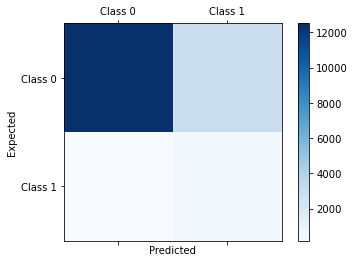

In [39]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

conf_mat = confusion_matrix(y_true=y_valid, y_pred=y_pred)
print('Confusion matrix:\n', conf_mat)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

### Code 3: the code above uses a simple "hold out" method to get the validation score. Use cross-validation to get a more stable estimation.

In [ ]:
from sklearn.model_selection import cross_val_score
cross_val_score(clf, df_upsampled, new_y, cv=5, scoring='f1_macro')

Overall, the model were tested on their own and with aplication of PCA with 100 most representative features. The best model unsurpsingly turned out out to be DNN model with best balanced accuracy on test submission data - 0.79. Though other models like Logistic Regression, XGBoost and Linear SVM shown 0.74, 0.76 and 0.74 accuracy respectively. With PCA the results turned out to be much worse by a few percent, that is why we only added a few features and removed unnecessary columns with ID fields.

# 4. Visualization

#### Labels distribution

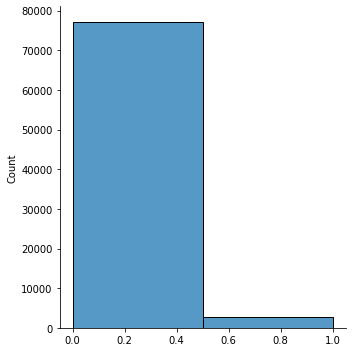

In [26]:
sns.displot(y, bins=2, kde=False)

We can see that before upsampling, the class were not well balanced

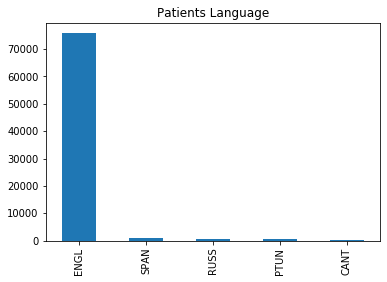

In [12]:
X['LANGUAGE'].value_counts()[:5].plot(kind='bar', title="Patients Language")

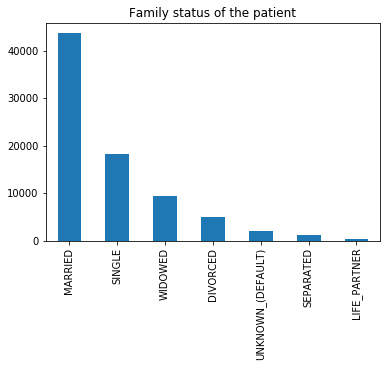

In [13]:
X['MARITAL_STATUS'].value_counts().plot(kind='bar', title="Family status of the patient")

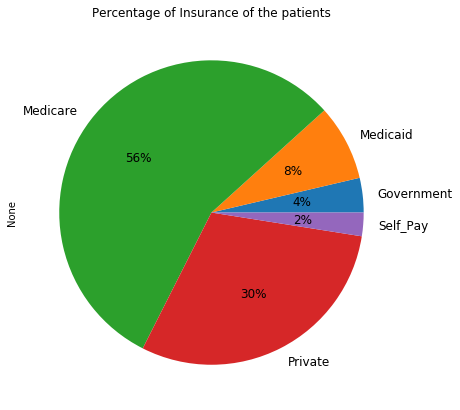

In [14]:
plt.figure(figsize=(7,7))
X.groupby('INSURANCE').size().plot(kind='pie',autopct='%1.0f%%',  textprops={'fontsize': 12}, title="Percentage of Insurance of the patients")
plt.show()

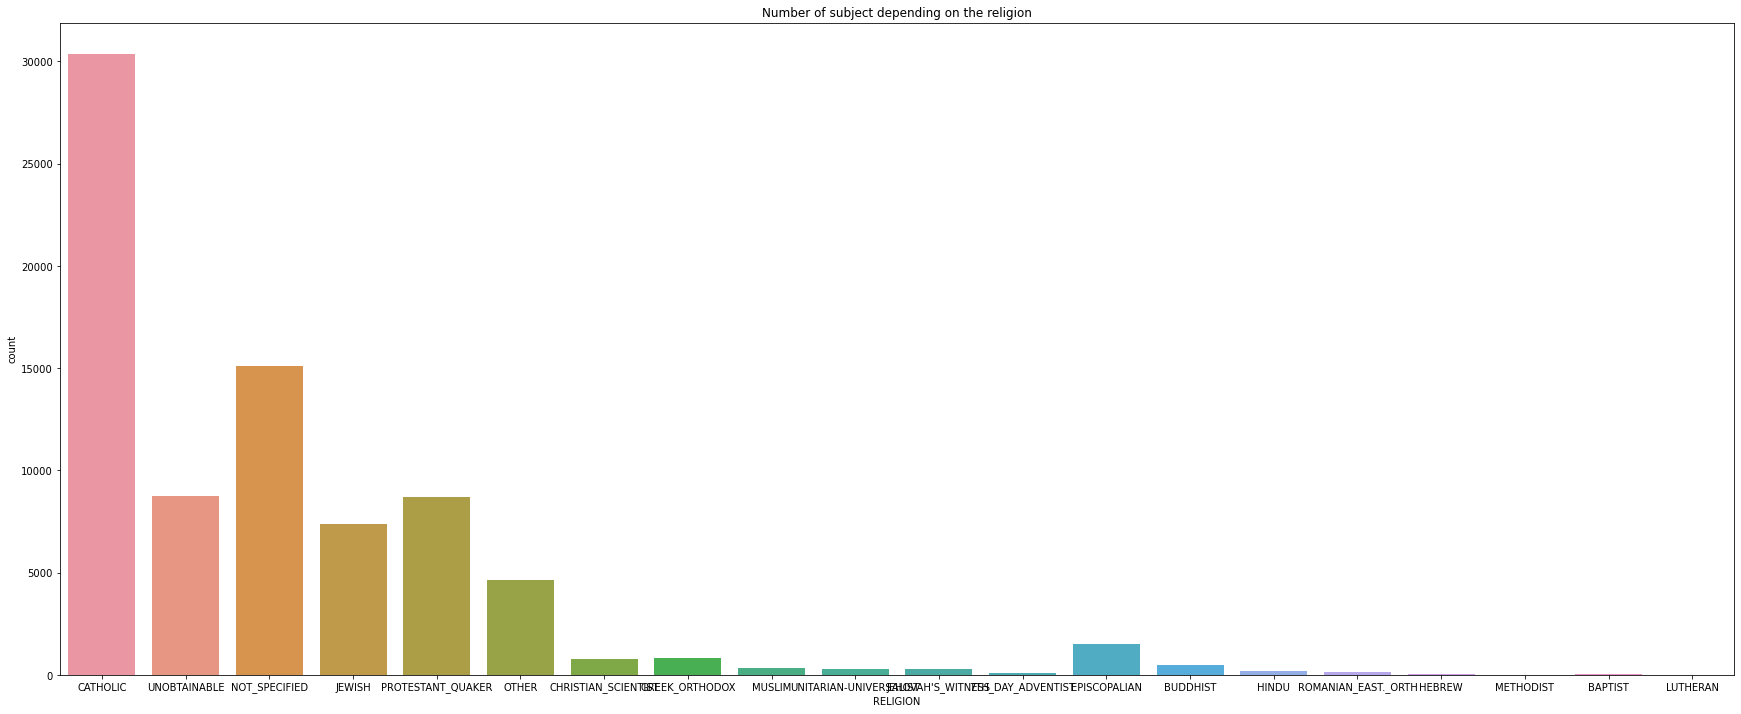

In [75]:
plt.figure(figsize=(30,12))

ax = sns.countplot(x="RELIGION", data=X).set_title("Number of subject depending on the religion")

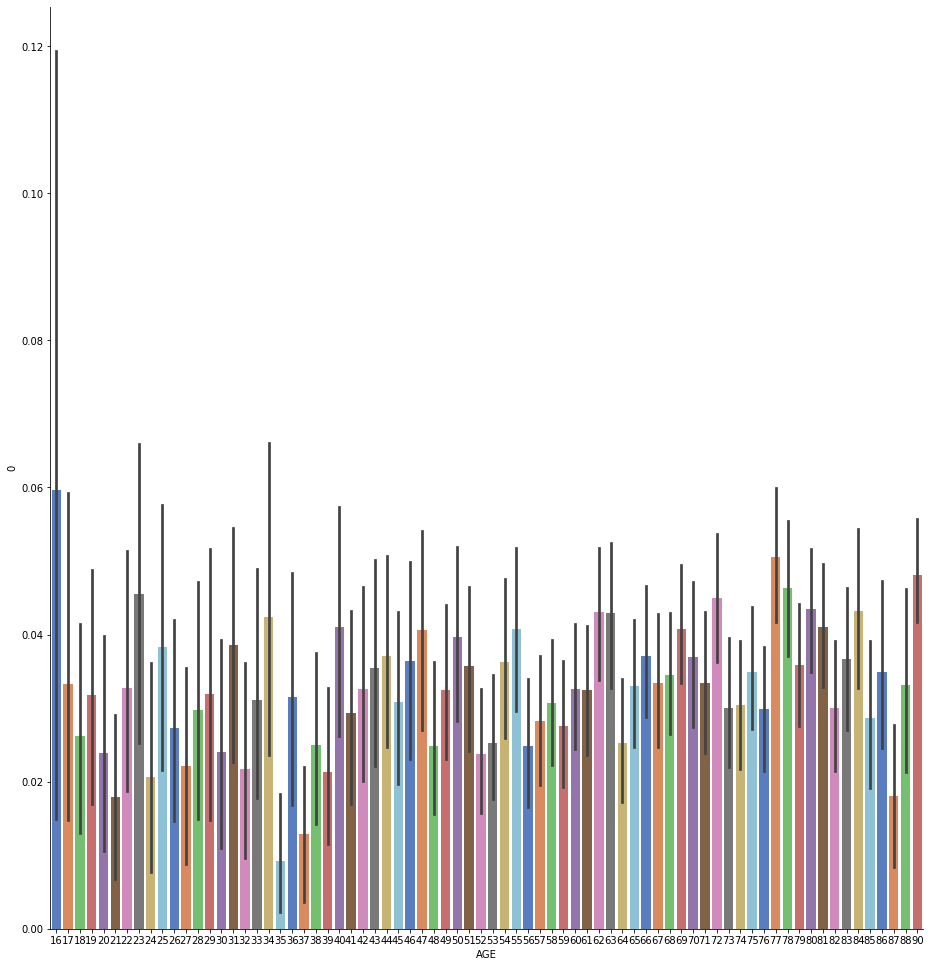

In [96]:

ages = X['AGE']
dlg = pd.concat([ages,y], axis=1)
g = sns.catplot(x="AGE", y=0,data=dlg, kind="bar", palette="muted")
g.fig.set_size_inches(15,15)

On this plot we can see the probability to die depending on the age

Text(0, 0.5, 'number of people alive')

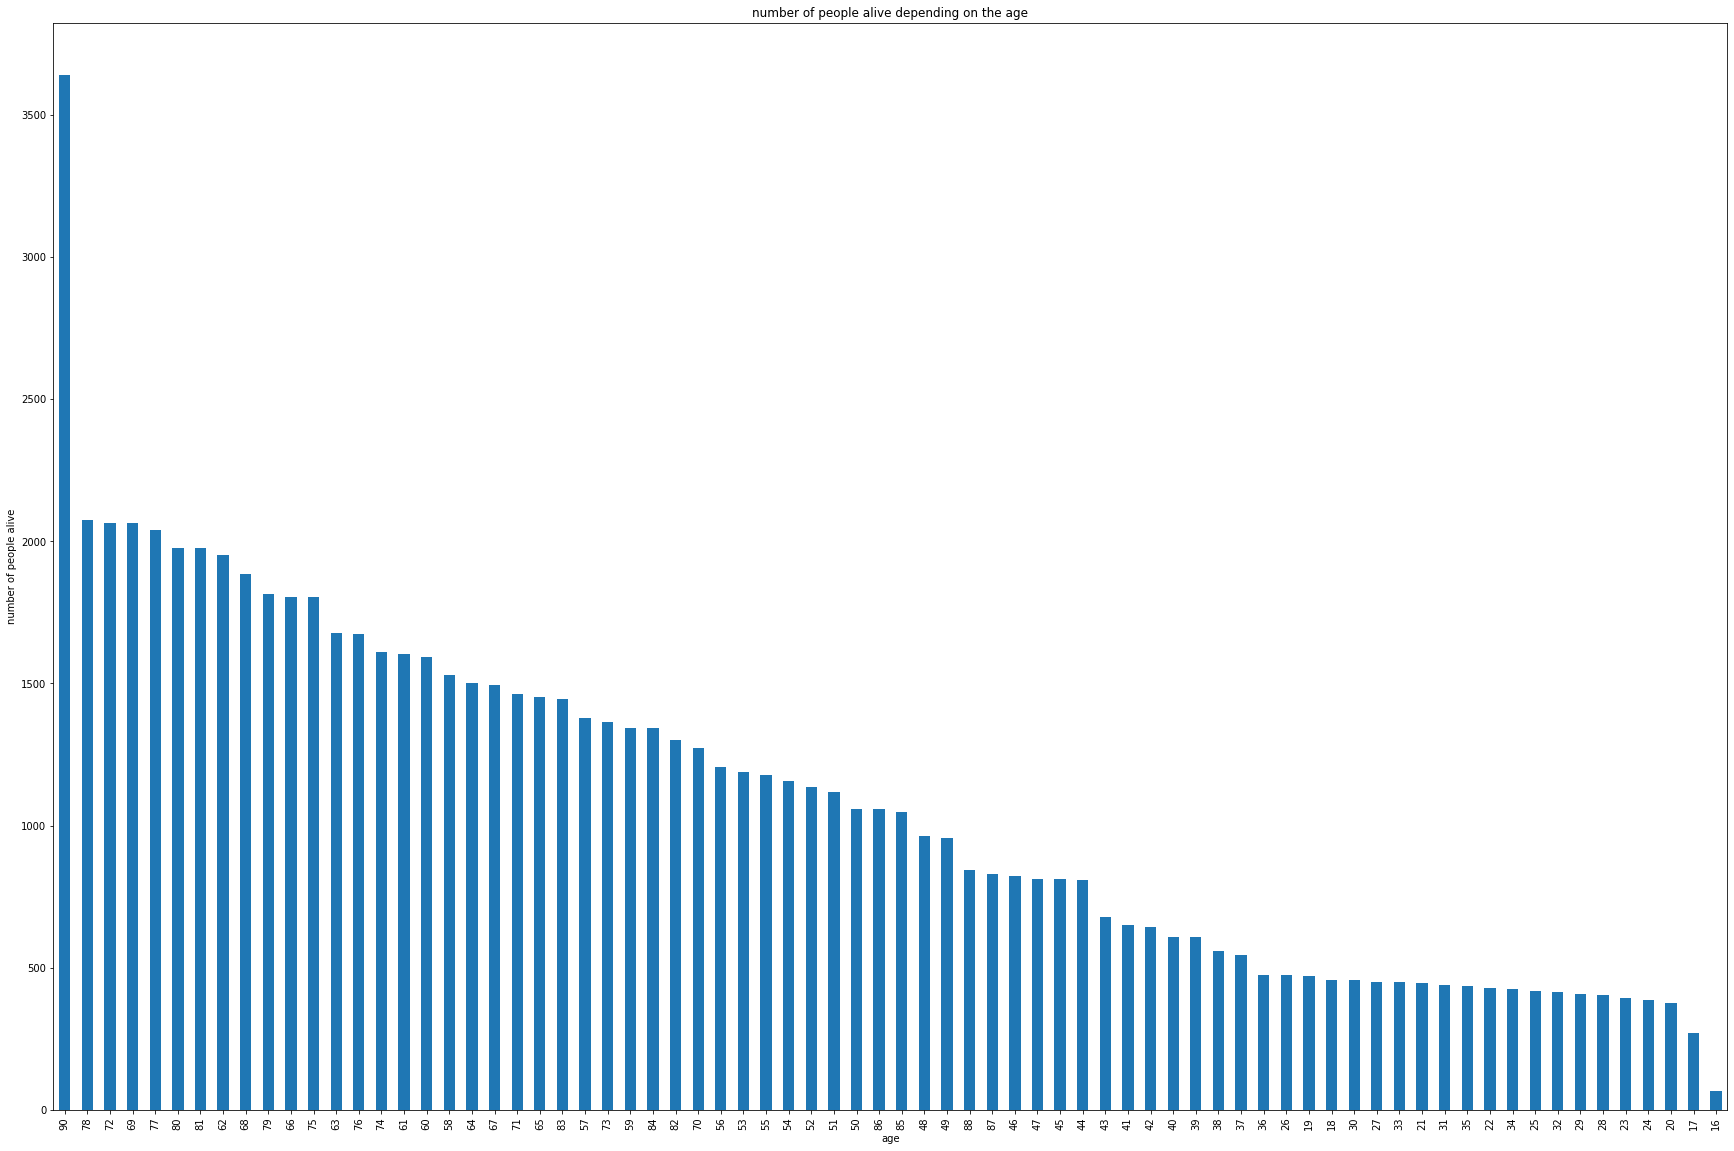

In [5]:
plt.figure(figsize=(30,20))

X["AGE"].value_counts().plot.bar()
plt.title("number of people alive depending on the age")
plt.xlabel("age")
plt.ylabel("number of people alive")

Text(0, 0.5, 'number of death')

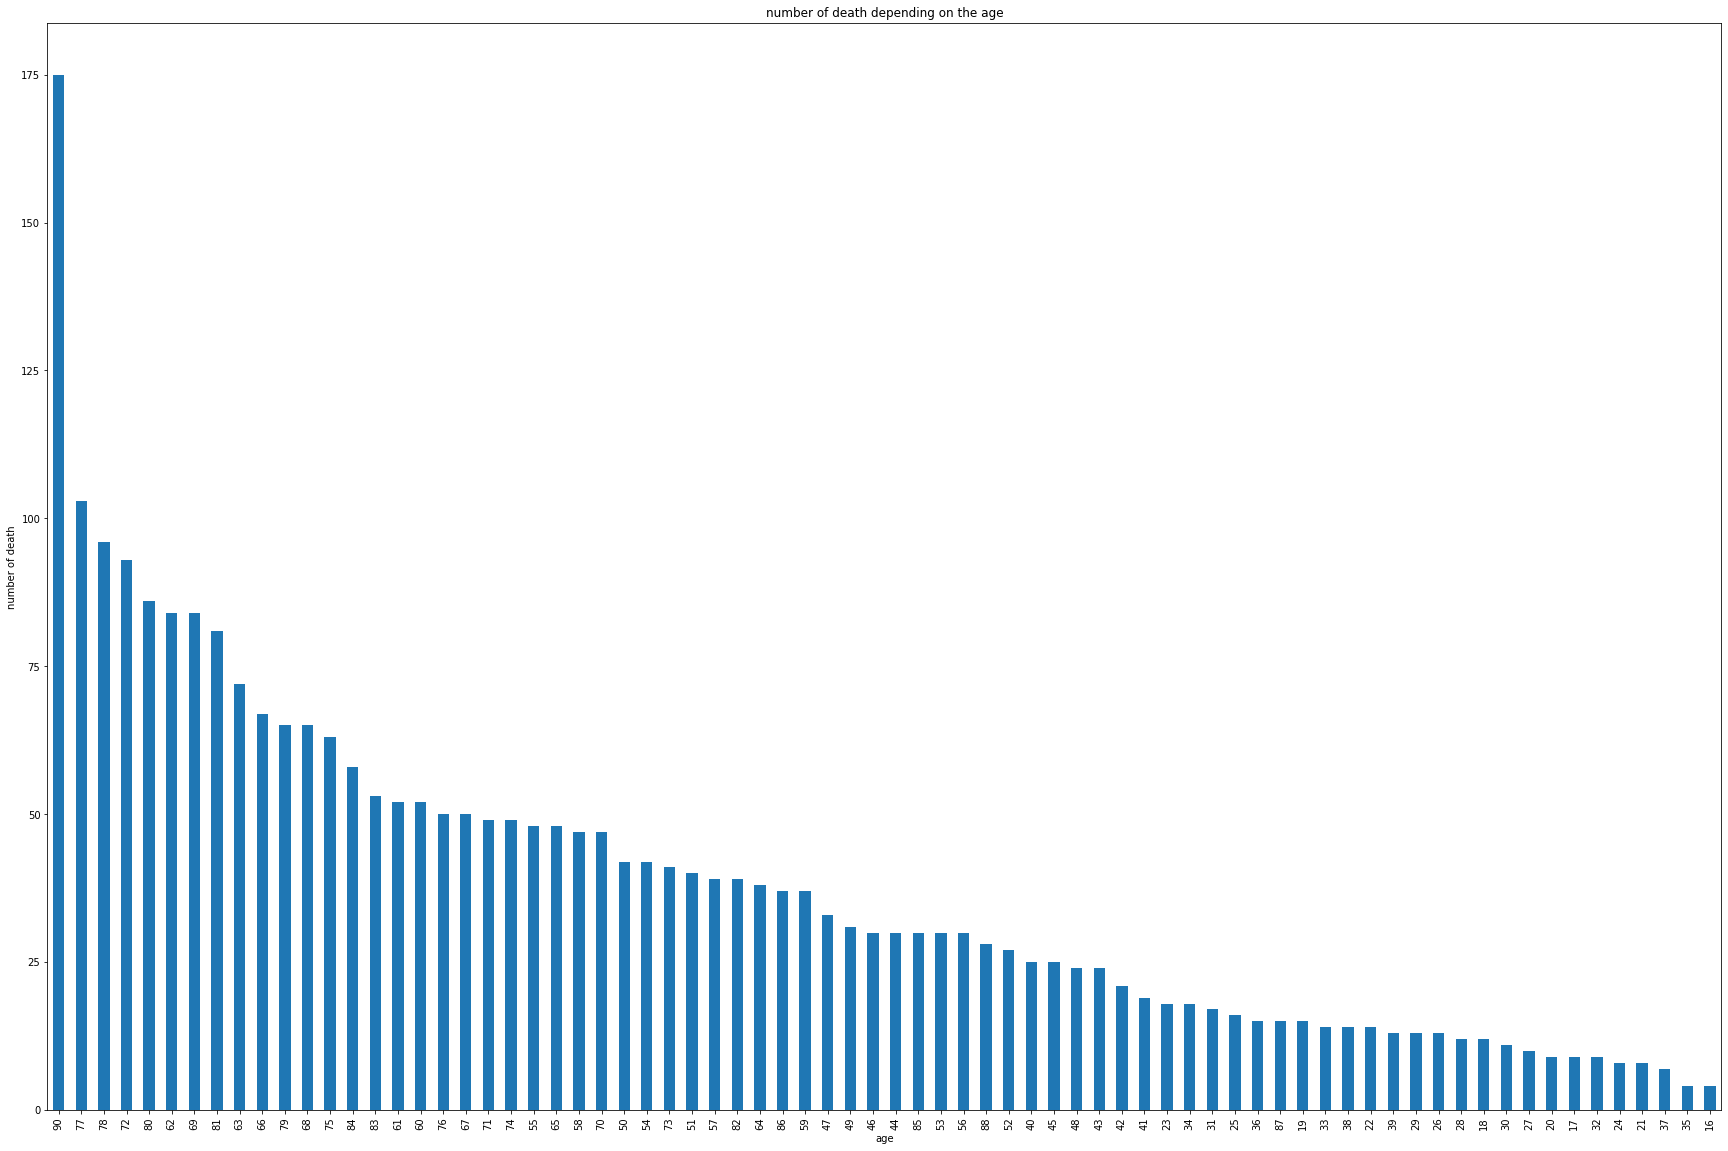

In [6]:
plt.figure(figsize=(30,20))
new_x = X[y==1]["AGE"]

new_x.value_counts().plot.bar()
plt.title("number of death depending on the age")
plt.xlabel("age")
plt.ylabel("number of death")

The two last plots explain the high variability of the th

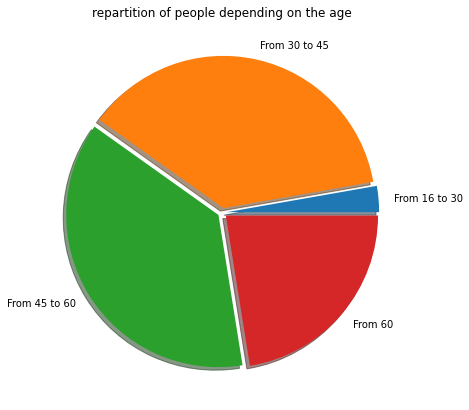

In [7]:
groups = [X[X['AGE'] <=30].shape[0], X[(X['AGE'] > 30) | (X['AGE'] <= 45)].shape[0], X[(X['AGE'] > 45) | (X['AGE'] <= 60)].shape[0], X[X['AGE'] > 60].shape[0]]
group_names = ["From 16 to 30", "From 30 to 45", "From 45 to 60", "From 60"]


plt.figure(figsize=(30,7))
myexplode = [0.03, 0.03, 0.03, 0.03]
plt.pie(groups, labels=group_names, explode=myexplode, shadow = True)
plt.title("repartition of people depending on the age")

plt.show()

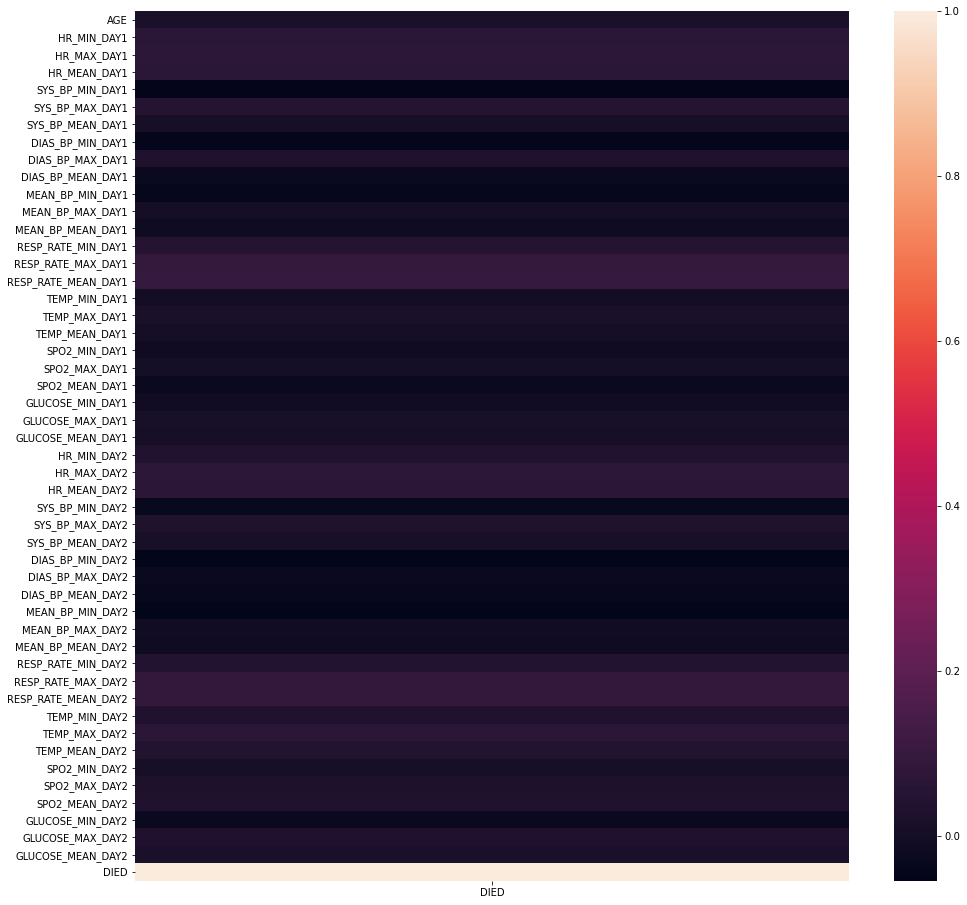

In [40]:
pour_corr = X.copy()

pour_corr = pour_corr[X.columns.values[2:60]]
pour_corr["DIED"] = y

corr = pour_corr.corr()

import seaborn as sns

plt.figure(figsize=(16, 16))

# print(corr)
vals = corr.values[:, -1].reshape(-1,1)

sns.heatmap(vals, 
        xticklabels=[corr.columns[-1]],
        yticklabels=corr.columns)

plt.show()

We can see that there are no direct correlation between these features and the fact that a person die

In [60]:
res = sorted(list(zip(corr.columns.tolist(), vals)), key=lambda a: a[1][0], reverse=True)
print("Top 3 most correlated numberical features")
res[1:4]

Top 3 most correlated numberical features


[('RESP_RATE_MEAN_DAY1', array([0.09577106])),
 ('RESP_RATE_MAX_DAY1', array([0.09064894])),
 ('RESP_RATE_MEAN_DAY2', array([0.08937976]))]

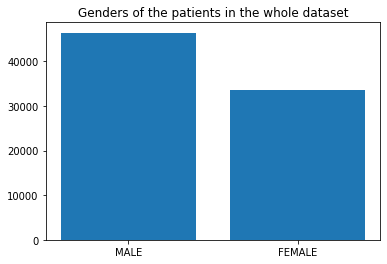

In [20]:
F = [len(X[X["GENDER"] == "M"]) , len(X[X["GENDER"] == "F"])]

plt.bar(["MALE","FEMALE"], F )
plt.title("Genders of the patients in the whole dataset")
plt.show()

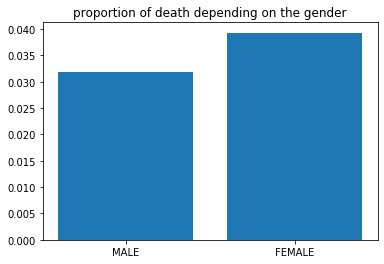

In [21]:
Xa = X.copy()
Xa["death"] = y
Xm = Xa[Xa["GENDER"] == "M"]
Xm = Xm[Xm["death"]==1]

Xf = Xa[Xa["GENDER"] == "F"]
Xf = Xf[Xf["death"]==1]

F2 = [len(Xm),len(Xf)]
F2 = np.divide(F2,F)
plt.title("proportion of death depending on the gender")
plt.bar(["MALE", "FEMALE"], F2)
plt.show()

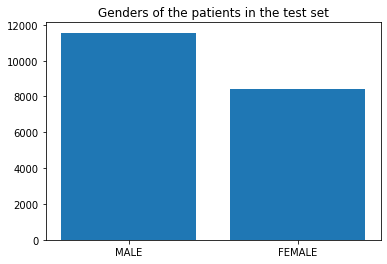

In [22]:
F = [len(X_test[X_test["GENDER"] == "M"]) , len(X_test[X_test["GENDER"] == "F"])]

plt.bar(["MALE","FEMALE"], F )
plt.title("Genders of the patients in the test set")
plt.show()

Text(0, 0.5, 'Accuracy')

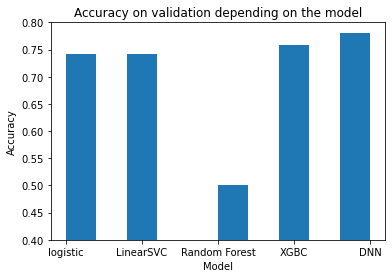

In [99]:
logistic_score = 0.741
LinearSVC_score = 0.7413
RandomForest_score = 0.5024339811742982
XGBC_score = 0.7587731019228132
DNN_score = 0.78

results = [logistic_score, LinearSVC_score, RandomForest_score, XGBC_score, DNN_score]
labels = ["logistic", "LinearSVC", "Random Forest", "XGBC", "DNN"]

ax = plt.hist(x=labels, weights=results)
plt.ylim(0.4, 0.8)
plt.title("Accuracy on validation depending on the model")
plt.xlabel("Model")
plt.ylabel("Accuracy")

No handles with labels found to put in legend.


[]

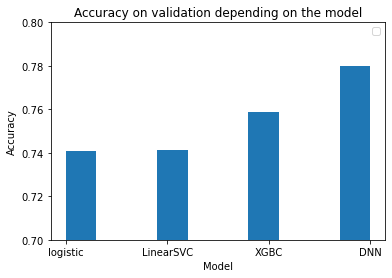

In [100]:
results = [logistic_score, LinearSVC_score, XGBC_score, DNN_score]
labels = ["logistic", "LinearSVC", "XGBC", "DNN"]

ax = plt.hist(x=labels, weights=results)
plt.ylim(0.70, 0.8)
plt.title("Accuracy on validation depending on the model")
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.legend()
plt.plot()

No handles with labels found to put in legend.


[]

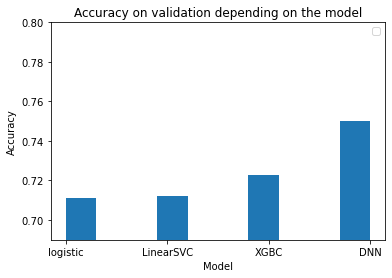

In [97]:
logistic_score = 0.711
LinearSVC_score = 0.712
RandomForest_score = 0.50132439811742982
XGBC_score = 0.723
DNN_score = 0.75

results = [logistic_score, LinearSVC_score, XGBC_score, DNN_score]
labels = ["logistic", "LinearSVC", "XGBC", "DNN"]

ax = plt.hist(x=labels, weights=results)
plt.ylim(0.69, 0.8)
plt.title("Accuracy on validation depending on the model")
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.legend()
plt.plot()

# 5. Save Predictions

* Use the following code to make predictions and save them as a ZIP file.
* Try to upload this ZIP file into the competition ("Participate > Submit/ View Results > Submit")
* Do your best to be **on top of the leaderboard!**

In [31]:
X_test_encoded_copy = X_test_encoded.copy()

# X_test_encoded_copy = mod.transform(X_test_encoded_copy)

X_test_encoded_copy= normalize(X_test_encoded_copy, use_saved=False)

In [32]:
predictions = model.predict(X_test_encoded_copy).reshape(-1)  # compute predictions (0 and 1)
predictions[predictions <= 0.5] = 0
predictions[predictions>0.5] = 1
predictions_file = "mimic_synthetic_test.csv"
pd.Series(predictions).to_csv(predictions_file, index=False, header = False)
print("Predictions saved.")
t = time.asctime().replace(" ", "_").replace(":", "-")
output_file = "submission_" + t + ".zip"
!zip test_submission.zip mimic_synthetic_test.csv # create a ZIP
with ZipFile(output_file, "w") as z:
    z.write(predictions_file)
print("The submission is ready: {}".format(output_file))

Predictions saved.
  adding: mimic_synthetic_test.csv (deflated 96%)
The submission is ready: submission_Sat_Dec__5_20-19-44_2020.zip


In [ ]:
X_test_encoded_copy.values.shape, x_valid.shape

### Interesting to know!

The dataset doesn't contain actual medical data. We are not allowed to share with you such **confidential data** from critical care patients. To avoid that problem, we replaced the data by **artificial data**. 

In order to have credible data, we have generated them using a **Wasserstein GAN**.

For more information, here is a reference: <br />
Privacy Preserving Synthetic Health Data <br />
Andrew Yale, Saloni Dash, Ritik Dutta, Isabelle Guyon, Adrien Pavao, Kristin Bennett <br />
https://hal.inria.fr/hal-02160496/document